In [44]:
import numpy as np
import numpy.fft as fft

import matplotlib
import matplotlib.pyplot as plt

import scipy.special as sp #bessel

In [45]:
"""initial parameter"""
Nx = 64
Ny = 64
NNy = int(Ny/2)+1
rho0 = 0.93
vac = 0.01
lc = (2.0*(1-vac)/3**0.5/rho0)**0.5
lx = lc
ly = lc*3**0.5
dx = lx/Nx
dy = ly/Ny
rho = np.zeros((Nx,Ny))

kx = np.zeros(Nx)
ky = np.zeros(NNy)

w1 = np.zeros((Nx,NNy))
w2 = np.zeros((Nx,NNy))
wx = np.zeros((Nx,NNy))
wy = np.zeros((Nx,NNy))
wxx = np.zeros((Nx,NNy))
wyy = np.zeros((Nx,NNy))
wxy = np.zeros((Nx,NNy))

a = 3.0
c0 = (a+2)/3
c1 = (a-4)/3
c2 = (2-2*a)/3
R = 0.5

In [46]:
"""initial density peak by Gaussian"""
def initial_rho(rho): 
    unit_x = lx/2
    unit_y = ly/2
    width = 25.0
    
    for i in range(Nx):
            for j in range(Ny):
                rho[i][j]=0
                for x in range(-1,int(lx/unit_x+1)):
                    for y in range(-1,int(ly/unit_y+1)):
                        if(x%2==0 and y%2 == 0):
                            disx = i*dx-x*unit_x
                            disy = j*dy-y*unit_y
                            dis = np.sqrt(disx**2+disy**2)
                            rho[i][j]+=width/np.pi*np.exp(-width*dis**2)
                        elif(x%2==1 and y%2 == 1):
                            disx = i*dx-x*unit_x
                            disy = j*dy-y*unit_y
                            dis = np.sqrt(disx**2+disy**2)
                            rho[i][j]+=width/np.pi*np.exp(-width*dis**2)
    print("avg density",np.sum(rho)/Nx/Ny/4*np.pi)
    rho=rho*(rho0/(np.sum(rho)/Nx/Ny))#correction of tail
    print("avg density",np.sum(rho)/Nx/Ny/4*np.pi)
    return rho

In [47]:
rho = initial_rho(rho)

avg density 0.7377857518875643
avg density 0.730420291959627


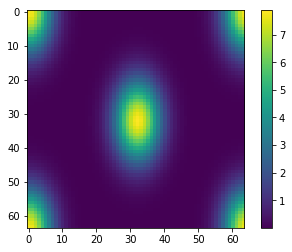

In [48]:
plt.imshow(rho)
plt.colorbar()

In [49]:
"""kernel of kx,ky, and w """

def initial_kernel():
    for i in range(Nx):
        n=i
        if (i>Nx/2):
            n = i-Nx
        kx[i] = n*2*np.pi/lx
    for j in range(NNy):
        ky[j] = j*2*np.pi/ly
        
    
    for i in range(Nx):
        for j in range(NNy):
            k = np.sqrt(kx[i]**2+ky[j]**2)
            w1[i][j]=2*np.pi*R*sp.j0(k*R)
            
    for i in range(Nx):
        for j in range(NNy):
            k = np.sqrt(kx[i]**2+ky[j]**2)
            w2[i][j]=2*np.pi/k*R*sp.j1(k*R)
    w2[0][0]=np.pi*R**2
    
    for i in range(Nx):
        for j in range(NNy):
            k = np.sqrt(kx[i]**2+ky[j]**2)
            wx[i][j]=-2*np.pi*R*kx[i]/k*sp.j1(k*R)
    wx[0][0]=0
    
    for i in range(Nx):
        for j in range(NNy):
            k = np.sqrt(kx[i]**2+ky[j]**2)
            wy[i][j]=-2*np.pi*R*ky[j]/k*sp.j1(k*R)
    wy[0][0]=0
    
    for i in range(Nx):
        for j in range(NNy):
            k = np.sqrt(kx[i]**2+ky[j]**2)
            wxx[i][j]=2*np.pi*(-R*kx[i]**2/k**2*sp.jv(2,k*R)+1.0/k*sp.j1(k*R))
    wxx[0][0]=np.pi*R
    
    for i in range(Nx):
        for j in range(NNy):
            k = np.sqrt(kx[i]**2+ky[j]**2)
            wxy[i][j]=2*np.pi*(-R*kx[i]*ky[j]/k**2*sp.jv(2,k*R))
    wxy[0][0]=0
    
    for i in range(Nx):
        for j in range(NNy):
            k = np.sqrt(kx[i]**2+ky[j]**2)
            wyy[i][j]=2*np.pi*(-R*ky[j]**2/k**2*sp.jv(2,k*R)+1.0/k*sp.j1(k*R))
    wyy[0][0]=np.pi*R

In [50]:
initial_kernel()

/home/sam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars
/home/sam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/sam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
/home/sam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/sam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
/home/sam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in double_scalars
/home/sam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
/home/sam/anaconda3/lib/python3.6/site-packages/ipykernel_la

In [63]:
"""weighted density and convolution"""

def cal_n1 (rho):
    return  fft.irfft2(fft.rfft2(rho)*w1)
def cal_n2 (rho):
    return  fft.irfft2(fft.rfft2(rho)*w2)
def cal_nx (rho):
    n1x = fft.rfft2(rho)*wx*1j
    for j in range(NNy):
        n1x[int(Nx/2)][j]=0 #kill nyquist frequency
    return  fft.irfft2(n1x)
def cal_ny (rho):
    n1y = fft.rfft2(rho)*wy*1j #1j for wy is imagenary part
    for i in range(Nx):
        n1y[i][int(Ny/2)]=0
    return  fft.irfft2(n1y)

def cal_nxx (rho):
    n = fft.rfft2(rho)*wxx
    return  fft.irfft2(n)

def cal_nyy (rho):
    n = fft.rfft2(rho)*wyy
    return  fft.irfft2(n)

def cal_nxy (rho):
    n = fft.rfft2(rho)*wxy
    for i in range(Nx):
        n[i][int(Ny/2)]=0
    for j in range(NNy):
        n[int(Nx/2)][j]=0
    return  fft.irfft2(n)

def cal_conv_nx (rho):
    n1x = fft.rfft2(rho)*wx*(-1j) # -1 for w(-r)=-w(r)
    for j in range(NNy):
        n1x[int(Nx/2)][j]=0
    return  fft.irfft2(n1x)

def cal_conv_ny (rho):
    n1y = fft.rfft2(rho)*wy*(-1j)
    for i in range(Nx):
        n1y[i][int(Ny/2)]=0
    return  fft.irfft2(n1y)



In [64]:
def cal_c1c(rho): #calculate delta F_exc / delta rho
    n1 = cal_n1(rho)
    n2 = cal_n2(rho)
    nx = cal_nx(rho)
    ny = cal_ny(rho)
    nxx = cal_nxx(rho)
    nxy = cal_nxy(rho)
    nyy = cal_nyy(rho)
    
    """partial Fx partial nx"""
    F1_n1 = -np.log(1-n2)/2.0/np.pi/R
    F1_n2 = n1/(1-n2)/2/np.pi/R
    F2_n1 = 1.0/4/np.pi/(1-n2)*(2*c0*n1)
    F2_n2 = 1.0/4/np.pi/(1-n2)**2*(c0*n1**2+c1*(nx**2+ny**2)
                                   +c2*(nxx**2+nyy**2+2*nxy**2))
    F2_nx = 1.0/4/np.pi/(1-n2)*(2*c1*nx)
    F2_ny = 1.0/4/np.pi/(1-n2)*(2*c1*ny)
    F2_nxx = 1.0/4/np.pi/(1-n2)*(2*c2*nxx)
    F2_nyy = 1.0/4/np.pi/(1-n2)*(2*c2*nyy)
    F2_nxy = 1.0/4/np.pi/(1-n2)*(2*c2*nxy)*2.0
    
    return (cal_n1(F1_n1)+cal_n1(F2_n1)+cal_n2(F1_n2)+cal_n2(F2_n2) 
            +cal_conv_nx(F2_nx)+cal_conv_ny(F2_ny)
            +cal_nxx(F2_nxx)+cal_nyy(F2_nyy)+cal_nxy(F2_nxy)
           )

def free_energy(rho):
    n1 = cal_n1(rho)
    n2 = cal_n2(rho)
    nx = cal_nx(rho)
    ny = cal_ny(rho)
    nxx = cal_nxx(rho)
    nxy = cal_nxy(rho)
    nyy = cal_nyy(rho)
    return (rho*(np.log(rho)-1)+
            (-n1/2/np.pi/R*np.log(1-n2)+
             1.0/4/np.pi/(1-n2)*
             (c0*n1**2+
              c1*(nx**2+ny**2)+
              c2*(nxx**2+2*nxy**2+nyy**2)))
            )
            

In [65]:
def picard_update(rho,mu_fix,alpha):
    c1c = cal_c1c(rho)
    mu = np.log(np.sum(rho)/np.sum(np.exp(-c1c))) # fix particle number 
    #mu = mu_fix #fix mu
    rho_new = np.exp(mu-c1c)
    rho = (1-alpha)*rho+alpha*rho_new
    error = np.sum((rho-rho_new)**2)/Nx/Ny
    return rho,error,mu

In [66]:
%%time
rho = np.zeros((Nx,Ny))
rho = np.full((Nx,Ny),rho0)#lazy way
mu_fix = cal_c1c(rho)[0]+np.log(rho0)
rho = np.zeros((Nx,Ny))
rho = initial_rho(rho)
error_array=np.zeros(0)
F_N_array=np.zeros(0)
mu_array=np.zeros(0)
thread = 10**-6 # not enough 
alpha = 10**-4
for i in range (100000):
    rho,error,mu = picard_update(rho,mu_fix,alpha)
    F=free_energy(rho)
    error_array=np.append(error_array,error)
    mu_array=np.append(mu_array,mu)
    F_N_array=np.append(F_N_array,np.sum(F)/(np.sum(rho)))
    if(i>100):
        alpha = 10**-3
    if(i%100==0):
        print(i,np.sum(F)/np.sum(rho),error,np.sum(rho)/Nx/Ny*np.pi/4,mu)
    if(error<thread):
        break
    if(np.isnan(error) or np.isnan(np.sum(F))):
        break
print(np.sum(F)/Nx/Ny)

avg density 0.7377857518875643
avg density 0.730420291959627
0 2.859431271410271 0.003143007907371137 0.730420291959627 13.499663220390016
100 2.859361419452219 0.0030683391775835757 0.7304202919596279 13.501451430297724
200 2.858747672303741 0.002751725138344451 0.7304202919596278 13.517984031052071
300 2.8582439514028555 0.002469986518096188 0.7304202919596278 13.533107420927323
400 2.8578282442211558 0.0022183118452351134 0.7304202919596277 13.546708265447162
500 2.857481717752124 0.0019933443341309046 0.7304202919596275 13.558961441176034
600 2.857190775568907 0.0017921219242332872 0.7304202919596275 13.5700162825865
700 2.856945155079265 0.001612028227653791 0.7304202919596275 13.580001258456656
800 2.856736883155999 0.0014507498826095522 0.7304202919596273 13.589027635376603
900 2.856559638621138 0.0013062394492597451 0.7304202919596273 13.597192376158239
1000 2.856408334423926 0.001176683101149557 0.7304202919596273 13.604580454384958
1100 2.8562788294550554 0.001060472466879270

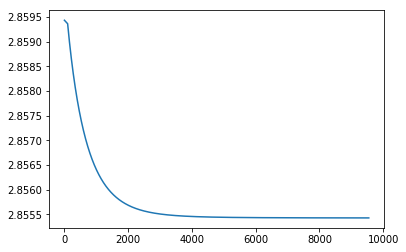

In [67]:
plt.plot(F_N_array)

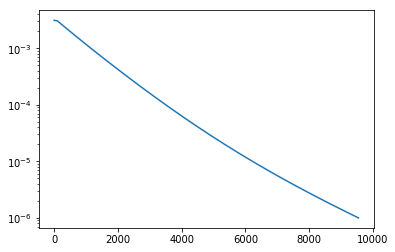

In [68]:
plt.semilogy(error_array)

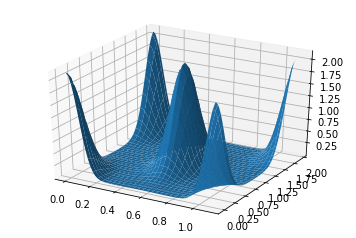

In [69]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
x = np.linspace(0,lx,Nx)
y = np.linspace(0,ly,Ny)
X, Y = np.meshgrid(x, y)
ax.plot_surface(X, Y, rho*R**2)

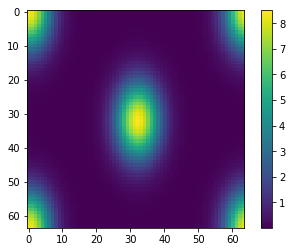

In [70]:
plt.imshow(rho)
plt.colorbar()

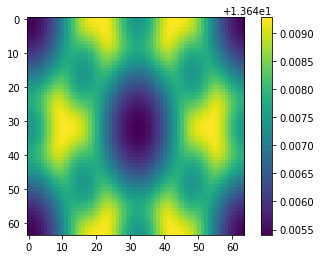

In [71]:
c1c = cal_c1c(rho)
plt.imshow(c1c+np.log(rho))
plt.colorbar()